In [1]:
# Import necessary packages
import zipfile
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import matplotlib.pyplot as plt
import math
from collections import Counter
from tqdm.notebook import tqdm
import seaborn as sns
from langdetect import DetectorFactory, detect
import pickle
import warnings
from sklearn.decomposition import PCA

# Preprocessing Data

In [2]:
# Initialize
DetectorFactory.seed = 0
western_lang = ["de", "en", "es", "it", "el", "nl", "da"]

# Create a unique folder to extract files
extracted_folder = "data/namesbystate_extracted"
if not os.path.exists(extracted_folder):
    with zipfile.ZipFile("data/namesbystate.zip", 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)

# Read Colorado-specific file
co_df = pd.read_csv(os.path.join(extracted_folder, "STATE.CO.txt"), header=None, names=["State", "Sex", "Year", "Name", "Count"])

# Aggregate for total count and most popular year in Colorado
co_aggregated = co_df.groupby(['Name', 'Sex']).agg({
    'Count': 'sum',
    'Year': lambda x: x.value_counts().idxmax()
}).reset_index()
co_aggregated.rename(columns={'Count': 'CO_Total_Count', 'Year': 'CO_Most_Popular_Year'}, inplace=True)

# Extracting zip file to a folder named "Extracted"
extracted_folder = "data/Extracted"

# Check if the folder already exists
if not os.path.exists(extracted_folder):
    with zipfile.ZipFile("data/names.zip", 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)

# Reading and merging all txt files
all_files = glob.glob(os.path.join(extracted_folder, "yob*.txt"))  # Adjusted path
df_list = []

for filename in all_files:
    year = filename[-8:-4]  # Extracting the year from filename
    df = pd.read_csv(filename, names=["Name", "Sex", "Count"])
    df['Year'] = int(year)  # Adding year column
    df_list.append(df)
    
# Concatenating all dataframes
all_names = pd.concat(df_list, ignore_index=True)

# Grouping by 'Name' and 'Sex', then aggregating
aggregated_names = all_names.groupby(['Name', 'Sex']).agg({
    'Count': 'sum',
    'Year': lambda x: x.value_counts().idxmax()  # Most frequent year
}).reset_index()
aggregated_names

# Renaming columns for clarity
aggregated_names.rename(columns={'Count': 'Total_Count', 'Year': 'Most_Popular_Year'}, inplace=True)
aggregated_names['Most_Popular_Year'] = aggregated_names['Most_Popular_Year'].fillna(0).astype(int)
aggregated_names.sort_values(by='Total_Count', ascending=False)

# Getting the most recent year in CO data
most_recent_year_CO = co_df['Year'].max()

# Filtering the most recent year data and aggregating counts by Name and Sex
co_recent_counts = co_df[co_df['Year'] == most_recent_year_CO].groupby(['Name', 'Sex'])['Count'].sum().reset_index()
co_recent_counts.rename(columns={'Count': 'Count_CO_Recent'}, inplace=True)
co_recent_counts.sort_values(by='Count_CO_Recent', ascending=False)

# Getting the most recent year in the original dataset
most_recent_year_all = aggregated_names['Most_Popular_Year'].max()

# Aggregated names should have a 'Year' column populated to filter
all_recent_counts = (all_names[all_names['Year'] == most_recent_year_all]
                     .rename(columns={'Count': 'Count_All_Recent'})
                     .drop(columns='Year'))
all_recent_counts.sort_values(by='Count_All_Recent', ascending=False)

# Adding counts from the most recent year in CO
aggregated_names = pd.merge(aggregated_names, co_recent_counts, on=['Name', 'Sex'], how='left')

# Adding counts from the most recent year in the original dataset
aggregated_names = pd.merge(aggregated_names, all_recent_counts[['Name', 'Sex', 'Count_All_Recent']], on=['Name', 'Sex'], how='left')

# Filling NA
aggregated_names['Count_CO_Recent'] = aggregated_names['Count_CO_Recent'].fillna(0).astype(int)
aggregated_names['Count_All_Recent'] = aggregated_names['Count_All_Recent'].fillna(0).astype(int)

# Reading the names rated by wife
rated_boys = pd.read_csv("data/baby_name_boy.txt", names=["Name", "Rating", "Sex"])
rated_girls = pd.read_csv("data/baby_name_girl.txt", names=["Name", "Rating", "Sex"])
rated_names = pd.concat([rated_boys, rated_girls], ignore_index=True)
rated_names = pd.merge(rated_names, aggregated_names[['Name', 'Sex', 'Total_Count', 'Most_Popular_Year']], 
                       on=['Name', 'Sex'], how='left')
rated_names['Total_Count'] = rated_names['Total_Count'].fillna(0).astype(int)
rated_names['Most_Popular_Year'] = rated_names['Most_Popular_Year'].fillna(0).astype(int)

# Merge Colorado-specific data into your existing dataframes
aggregated_names = pd.merge(aggregated_names, co_aggregated, on=['Name', 'Sex'], how='left')
rated_names = pd.merge(rated_names, co_aggregated, on=['Name', 'Sex'], how='left')

rated_names = pd.merge(rated_names, co_recent_counts, on=['Name', 'Sex'], how='left')
rated_names = pd.merge(rated_names, all_recent_counts, on=['Name', 'Sex'], how='left')

# Fill NA values for the new columns
for df in [aggregated_names, rated_names]:
    df.loc[df['CO_Most_Popular_Year'].isna(), 'CO_Most_Popular_Year'] = df['Most_Popular_Year']
    df['Count_All_Recent'] = df['Count_All_Recent'].fillna(0).astype(int)
    df['Count_CO_Recent'] = df['Count_CO_Recent'].fillna(0).astype(int)
    df['CO_Total_Count'] = df['CO_Total_Count'].fillna(0).astype(int)
    df.loc[df['CO_Most_Popular_Year'].isna(), 'CO_Most_Popular_Year'] = df['Most_Popular_Year']
    df['CO_Most_Popular_Year'] = df['CO_Most_Popular_Year'].astype(int)
        
aggregated_names = aggregated_names[['Name', 'Sex', 'Total_Count', 'Count_All_Recent', 'Most_Popular_Year', 'CO_Total_Count', 'Count_CO_Recent', 'CO_Most_Popular_Year']]
rated_names = rated_names[['Name', 'Sex', 'Total_Count', 'Count_All_Recent', 'Most_Popular_Year', 'CO_Total_Count', 'Count_CO_Recent', 'CO_Most_Popular_Year', 'Rating']]

In [3]:
tqdm.pandas()

# Function to save DataFrame to a pickle file
def save_to_pickle(df, filename):
    with open(filename, 'wb') as f:
        pickle.dump(df, f)

# Function to load DataFrame from a pickle file
def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def syllable_count(word):
    vowels = "aeiouy"
    word = word.lower()
    count = 0
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

def entropy(string):
    p, lns = Counter(string), float(len(string))
    return -sum(count/lns * math.log(count/lns, 2) for count in p.values())

def feature_engineering(df):
    # Existing features
    df['Length'] = df['Name'].progress_apply(len)
    df['Vowels'] = df['Name'].progress_apply(lambda x: sum(1 for char in x.lower() if char in 'aeiou'))
    df['Consonants'] = df['Length'] - df['Vowels']
    df['Sex'] = df['Sex'].progress_apply(lambda x: 1 if x == 'M' else 0)
    df['Has_Repeating'] = df['Name'].progress_apply(lambda x: 1 if max(Counter(x).values()) > 1 else 0)
    df['Ends_with_Vowel'] = df['Name'].progress_apply(lambda x: 1 if x[-1].lower() in 'aeiou' else 0)
    df['Starts_with_Vowel'] = df['Name'].progress_apply(lambda x: 1 if x[0].lower() in 'aeiou' else 0)
    df['Syllable_Count'] = df['Name'].progress_apply(syllable_count)
    df['Name_Entropy'] = df['Name'].progress_apply(entropy)
    df['Language_Root'] = df['Name'].progress_apply(lambda x: 1 if detect(x) in western_lang else 0)
    return df

In [4]:
# Define the name of the saved file
saved_filename = 'data/all_names.pkl'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Check if the saved file exists
    if os.path.exists(saved_filename):
        print("Loading data from saved file.")
        all_names = load_from_pickle(saved_filename)
    else:
        print("File not found. Running the feature engineering process.")

        # Run your existing code to create 'all_names'
        all_names = feature_engineering(aggregated_names)

        # Save 'all_names' to a file for future use
        save_to_pickle(all_names, saved_filename)
    rated_names = feature_engineering(rated_names)

feature_cols = [col for col in all_names.columns if col != 'Name']

Loading data from saved file.


  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 0/2142 [00:00<?, ?it/s]

  0%|          | 0/2142 [00:00<?, ?it/s]

In [5]:
X = rated_names[feature_cols].values
y = rated_names["Rating"].values
y = y - 1

class_names = np.sort(pd.DataFrame(y)[0].unique())

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models

In [6]:
def plot_percentage_conf_matrix(conf_matrix, class_labels):
    row_sums = conf_matrix.sum(axis=1)
    norm_conf_matrix = conf_matrix / row_sums[:, np.newaxis]
    percentage_matrix = np.round(norm_conf_matrix * 100, 2)
    
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10, 8))
    sns.heatmap(percentage_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    
    plt.title("Confusion Matrix (Percentage)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

## XGBoost

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\clopt\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best xgb parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}
XGBoost Accuracy: 0.351981351981352
XGBoost F1 Score: 0.16678119078872525


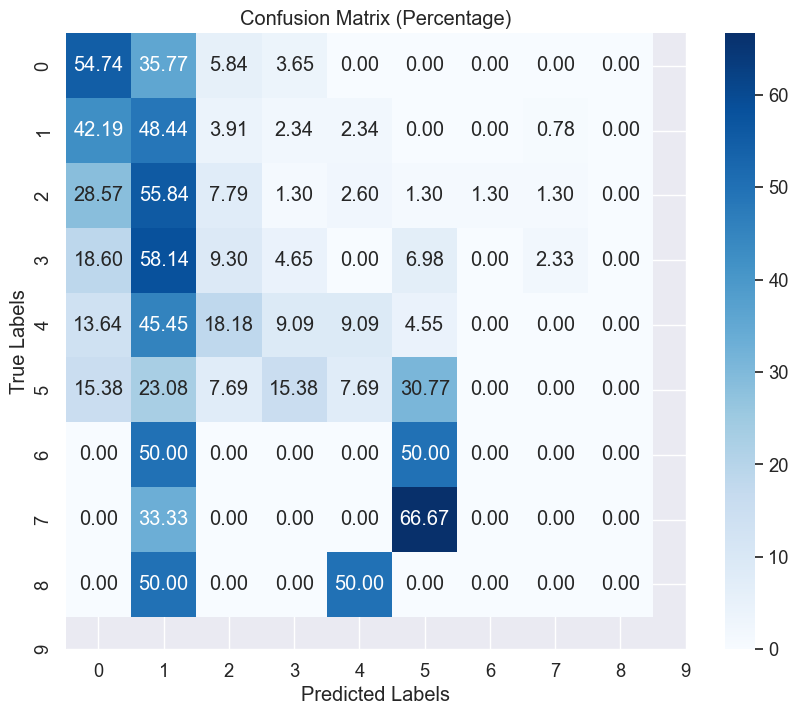

In [7]:
# Create the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)))

# Set up hyperparameter grid for search
xgb_param_grid = {
    'n_estimators': [50, 100, 150, 250],
    'learning_rate': [.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6]
}

# Set up GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=xgb_param_grid, 
                           cv=cv, 
                           scoring='f1_weighted', 
                           verbose=1)

# Fit the model
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters
xgb_best_params = xgb_grid_search.best_params_
print(f"Best xgb parameters: {xgb_best_params}")

# Evaluate the model with best parameters
xgb_best_model = xgb_grid_search.best_estimator_
xgb_y_pred = xgb_best_model.predict(X_test)

# Evaluation metrics
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred, average='macro')
xgb_conf_matrix = confusion_matrix(y_test, xgb_y_pred)

print(f"XGBoost Accuracy: {xgb_accuracy}")
print(f"XGBoost F1 Score: {xgb_f1}")
plot_percentage_conf_matrix(xgb_conf_matrix, class_names)

## Random Forest

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\clopt\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best rf parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 150}
Random Forest Accuracy: 0.32634032634032634
Random Forest F1 Score: 0.32412757322689645


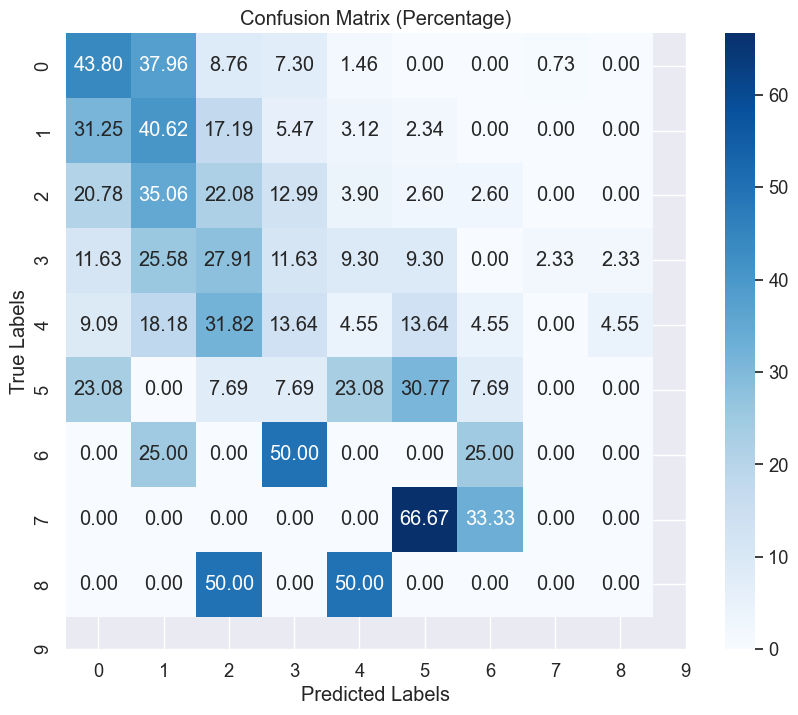

In [8]:
# Create the random forest model
rf_model = RandomForestClassifier(class_weight='balanced')

# Set up hyperparameter grid for search
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=rf_param_grid, 
                           cv=cv, 
                           scoring='f1_weighted', 
                           verbose=1)

# Fit the model
rf_grid_search.fit(X_train, y_train)

# Get the best parameters
rf_best_params = rf_grid_search.best_params_
print(f"Best rf parameters: {rf_grid_search.best_params_}")

# Evaluate the model with best parameters
rf_best_model = rf_grid_search.best_estimator_
rf_y_pred = rf_best_model.predict(X_test)

# Evaluation metrics
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred, average='weighted')
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest F1 Score: {rf_f1}")
plot_percentage_conf_matrix(rf_conf_matrix, class_names)

## Support Vector Machine

In [9]:
# Apply PCA
n_components = 10 
svm_pca = PCA(n_components=n_components)
svm_X_train_pca = svm_pca.fit_transform(X_train)
svm_X_test_pca = svm_pca.transform(X_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\clopt\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best svm parameters: {'C': 100, 'gamma': 0.1}
SVM Accuracy: 0.2680652680652681
SVM F1 Score: 0.27607892352572194


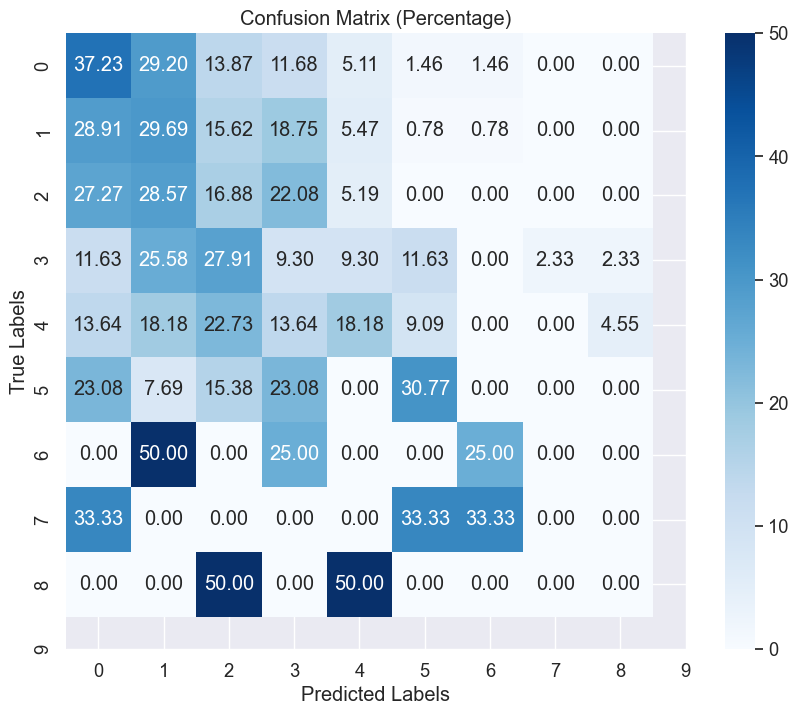

In [10]:
# Create the SVM model
svm_model = SVC(kernel='rbf', class_weight='balanced')

# Set up hyperparameter grid for search
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
}

# Set up GridSearchCV
svm_grid_search = GridSearchCV(estimator=svm_model, 
                           param_grid=svm_param_grid, 
                           cv=cv, 
                           scoring='f1_weighted', 
                           verbose=1)

# Fit the model
svm_grid_search.fit(svm_X_train_pca, y_train)

# Get the best parameters
svm_best_params = svm_grid_search.best_params_
print(f"Best svm parameters: {svm_grid_search.best_params_}")

# Evaluate the model with best parameters
svm_best_model = svm_grid_search.best_estimator_
svm_y_pred = svm_best_model.predict(svm_X_test_pca)

# Evaluation metrics
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_f1 = f1_score(y_test, svm_y_pred, average='weighted')
svm_conf_matrix = confusion_matrix(y_test, svm_y_pred)

print(f"SVM Accuracy: {svm_accuracy}")
print(f"SVM F1 Score: {svm_f1}")
plot_percentage_conf_matrix(svm_conf_matrix, class_names)

## K-Nearest Neighbors

In [11]:
# Apply PCA
n_components = 10 
knn_pca = PCA(n_components=n_components)
knn_X_train_pca = knn_pca.fit_transform(X_train)
knn_X_test_pca = knn_pca.transform(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\clopt\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best svm parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
KNN Accuracy: 0.32867132867132864
KNN F1 Score: 0.2916584998340771


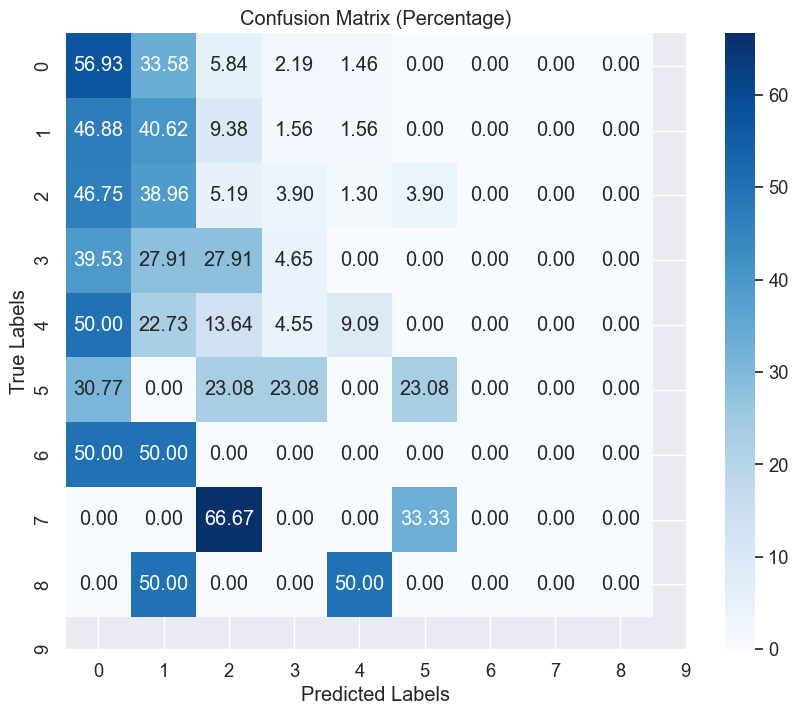

In [12]:
# Create the KNN model
knn_model = KNeighborsClassifier()

# Set up hyperparameter grid for search
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Set up GridSearchCV
knn_grid_search = GridSearchCV(estimator=knn_model, 
                           param_grid=knn_param_grid, 
                           cv= cv, 
                           scoring='f1_weighted', 
                           verbose=1)

# Fit the model
knn_grid_search.fit(knn_X_train_pca, y_train)

# Get the best parameters
knn_best_params = knn_grid_search.best_params_
print(f"Best svm parameters: {knn_grid_search.best_params_}")

# Evaluate the model with best parameters
knn_best_model = knn_grid_search.best_estimator_
knn_y_pred = knn_best_model.predict(knn_X_test_pca)

# Evaluation metrics
knn_y_pred = knn_grid_search.predict(knn_X_test_pca)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_f1 = f1_score(y_test, knn_y_pred, average='weighted')
knn_conf_matrix = confusion_matrix(y_test, knn_y_pred)

print(f"KNN Accuracy: {knn_accuracy}")
print(f"KNN F1 Score: {knn_f1}")
plot_percentage_conf_matrix(knn_conf_matrix, class_names)

## Tensorflow Deep Learning

In [13]:
from tensorflow.keras.callbacks import Callback
from IPython.display import display, clear_output

class SingleLineProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        metrics_str = " - ".join([f"{key}: {val:.4f}" for key, val in logs.items()])
        clear_output(wait=True)
        display(f"Epoch {epoch + 1}: {metrics_str}")

Best neuron combination: (32, 16) with F1 Score: 0.34335467539332987
Tensorflow Accuracy: 0.3543123543123543
Tensorflow F1 Score: 0.34335467539332987


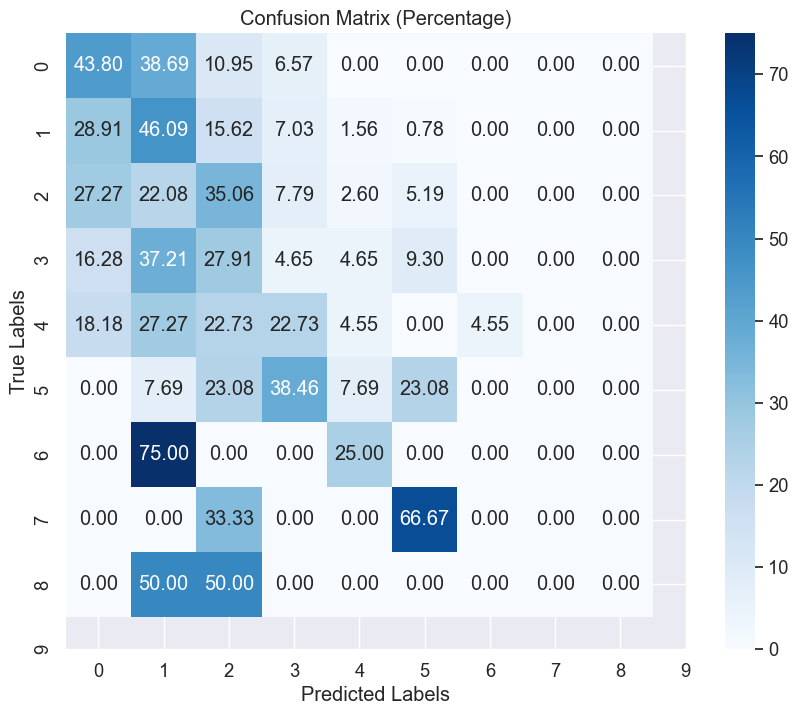

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.utils import to_categorical

# Define function for creating the neural network model
def create_tf_model(neuron1, neuron2):
    tf_model = Sequential([
        Dense(neuron1, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(neuron2, activation='relu'),
        Dense(10, activation='softmax')  # Assuming 10 classes
    ])
    tf_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=[F1Score(average='weighted')])
    return tf_model

# One-hot encoding for target labels
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Set up hyperparameter grid for search
neuron_combinations = [(16, 16), (32, 16), (32, 32), (64, 32), (64, 64), (64, 128), (128, 128)]

best_f1 = 0
best_neuron_combo = None
best_tf_model = None

for neuron1, neuron2 in neuron_combinations:
    # Create the neural network model
    tf_model = create_tf_model(neuron1, neuron2)

    # Fit the model
    tf_model.fit(X_train, 
                 y_train_one_hot, 
                 epochs=100, 
                 batch_size=16, 
                 verbose=0)  # Disable the default progress bar
    
    # Evaluation metrics
    tf_y_pred_probs = tf_model.predict(X_test, verbose=0)
    tf_y_pred = np.argmax(tf_y_pred_probs, axis=1)
    tf_f1 = f1_score(y_test, tf_y_pred, average='weighted')
    
    if tf_f1 > best_f1:
        best_f1 = tf_f1
        best_neuron_combo = (neuron1, neuron2)
        best_tf_model = tf_model

# Use the best model found
print(f"Best neuron combination: {best_neuron_combo} with F1 Score: {best_f1}")

tf_y_pred_probs = best_tf_model.predict(X_test, verbose=0)
tf_y_pred = np.argmax(tf_y_pred_probs, axis=1)
tf_accuracy = accuracy_score(y_test, tf_y_pred)
tf_conf_matrix = confusion_matrix(y_test, tf_y_pred)

print(f"Tensorflow Accuracy: {tf_accuracy}")
print(f"Tensorflow F1 Score: {best_f1}")
plot_percentage_conf_matrix(tf_conf_matrix, class_names)

# Results

<Axes: title={'center': 'Accuracy and F1 Scores for Models'}, xlabel='Model'>

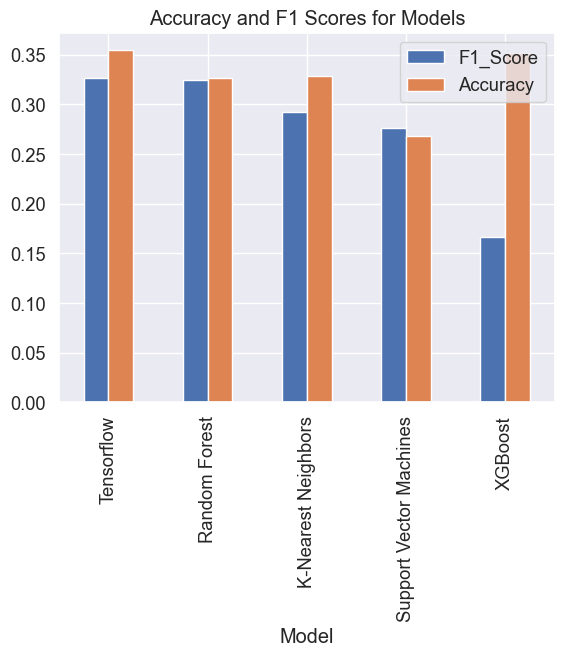

In [19]:
data = {
    'Model': ['XGBoost', 'Random Forest', 'Support Vector Machines', 'K-Nearest Neighbors', 'Tensorflow'],
    'F1_Score': [xgb_f1, rf_f1, svm_f1, knn_f1, tf_f1],
    'Accuracy': [xgb_accuracy, rf_accuracy, svm_accuracy, knn_accuracy, tf_accuracy]
}

pd.DataFrame(data).sort_values(by='F1_Score', ascending=False).plot(kind='bar', x='Model', title="Accuracy and F1 Scores for Models")

In [16]:
# Feature Scaling
all_names_features = all_names[feature_cols].values  
all_names_scaled = scaler.transform(all_names_features) 

# Prediction using trained models
rf_predictions_all_names = rf_best_model.predict(all_names_scaled)
xgb_predictions_all_names = xgb_best_model.predict(all_names_scaled)
svm_predictions_all_names = svm_best_model.predict(svm_pca.transform(all_names_scaled))
knn_predictions_all_names = knn_best_model.predict(knn_pca.transform(all_names_scaled))
tf_all_names_pred_probs  = tf_model.predict(all_names_scaled, verbose=0)
tf_predictions_all_names = np.argmax(tf_all_names_pred_probs, axis=1)

# Add these predictions back to the all_names dataframe
all_names['RF_Predicted_Rating'] = rf_predictions_all_names
all_names['XGB_Predicted_Rating'] = xgb_predictions_all_names
all_names['SVM_Predicted_Rating'] = svm_predictions_all_names
all_names['KNN_Predicted_Rating'] = knn_predictions_all_names
all_names['Tensorflow_Predicted_Rating'] = tf_predictions_all_names
all_names['Average_Predicted_Rating'] = all_names[['RF_Predicted_Rating', 'XGB_Predicted_Rating', 'SVM_Predicted_Rating', 'KNN_Predicted_Rating', 'Tensorflow_Predicted_Rating']].mean(axis=1).round(1)

# Add 1 back to predictions to scale between 1 and 10
columns_to_update = ['RF_Predicted_Rating', 'XGB_Predicted_Rating', 'SVM_Predicted_Rating', 
                     'KNN_Predicted_Rating', 'Tensorflow_Predicted_Rating', 'Average_Predicted_Rating']
all_names[columns_to_update] += 1

# Find top names

In [20]:
# Highlighted rows are names already submitted by my wife
def highlight_rows(row):
    if row['Name'] in rated_names['Name'].values:
        return ['background-color: lightyellow']*row.shape[0]
    else:
        return ['background-color: white']*row.shape[0]

highlighted_df = (all_names[all_names['Sex']==1]
                  .sort_values(by='Average_Predicted_Rating', ascending=False)
                  .reset_index(drop=True)[['Name', 
                                           'RF_Predicted_Rating', 
                                           'XGB_Predicted_Rating', 
                                           'SVM_Predicted_Rating', 
                                           'KNN_Predicted_Rating', 
                                           'Tensorflow_Predicted_Rating', 
                                           'Average_Predicted_Rating']]
                  .head(50))

highlighted_df.style.apply(highlight_rows, axis=1)